## This is a computational notebook to investigate the impact of increasing EVs,PVs and HPs penetration in computational burden.

### Pre-Run functions and Neccessary libraries

In [1]:
##################----------------- Import Libraries -------------########################

from pyomo.environ import *
from pyomo.opt import SolverFactory
import math
import os
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.pf as pf
from pandapower import networks
import pandapower.plotting as plot
import pandapower.networks as pn
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import t
import sys
current_directory = os.getcwd()

random.seed(42)  # βάζεις οποιονδήποτε αριθμό, π.χ. 42


In [2]:
# For auto reload libraries without the need to restart kernel
############# USE ONLY IN DEVELOPING MODE FOR EASIER MODIFICAITON IN LIBRARIES ##############
%load_ext autoreload
%autoreload 2

In [3]:
############ EV Statistical Data [t-distribution function] ###############

def truncated_t_sample(df, loc, scale, a, b, size=1):
    # Rejection sampling method for truncation
    samples = []
    while len(samples) < size:
        x = t.rvs(df, loc=loc, scale=scale, size=1)[0]
        if a <= x <= b:
            samples.append(x)
    return np.array(samples)

df_arrival=2.934714059633309
loc_arrival=17.34845275357045
scale_arrival=1.8215796521345204
a=0
b=23


df_departure=1.6256952809544216
loc_departure=7.365780910742849
scale_departure=0.694349558626649


values_weekdays = pd.Index([ 10.0,  20.0,  30.0,  15.0,  40.0,   5.0,   0.0,  50.0,  12.0,  25.0, 8.0, 200.0,  60.0,  70.0, 100.0,   7.0,  80.0,   2.0,   3.0,  35.0,
       140.0,   4.0,   6.0,   1.0, 150.0, 160.0,  55.0,  90.0, 250.0,  22.0, 45.0,   9.0,  14.0, 170.0,  75.0,  32.0,  13.0,  16.0,  17.0, 190.0,
        11.0, 125.0, 135.0,  92.0,  44.0, 180.0,  48.0,  10.5,  18.0,  43.0, 36.0,  56.0, 130.0, 110.0,   4.6,  61.0,   0.5,   6.2, 10.68,  2.74, 120.0, 161.0, 165.0
], name="Survey weekdays")

probabilities_weekdays = pd.Series({
    10.00: 0.118943, 20.00: 0.083700, 30.00: 0.079295, 15.00: 0.068282, 40.00: 0.052863, 5.00:  0.052863, 0.00:  0.046256, 50.00: 0.035240,
    12.00: 0.030837, 25.00: 0.030837, 8.00:  0.028634, 200.00: 0.026432, 60.00: 0.022026, 70.00: 0.022026, 100.00: 0.022026, 7.00:  0.017621,
    80.00: 0.017621, 2.00:  0.017621, 3.00:  0.015419, 35.00: 0.013216,140.00: 0.013216, 4.00:  0.013216,6.00:  0.013216,1.00:  0.011013,150.00: 0.011013,
    160.00: 0.008811, 55.00: 0.008811,90.00: 0.006608,250.00: 0.006608,22.00: 0.006608,45.00: 0.006608,9.00:  0.004405,14.00: 0.004405, 170.00: 0.004405,
    75.00: 0.004405,32.00: 0.004405, 13.00: 0.004405, 16.00: 0.004405,17.00: 0.004405, 190.00: 0.004405,11.00: 0.004405, 125.00: 0.002203, 135.00: 0.002203,
    92.00: 0.002203,44.00: 0.002203,180.00: 0.002203,48.00: 0.002203, 10.50: 0.002203,18.00: 0.002203, 43.00: 0.002203, 36.00: 0.002203,56.00: 0.002203,
    130.00: 0.002203,110.00: 0.002203,4.60:  0.002203,61.00: 0.002203,0.50:  0.002203,6.20:  0.002203,10.68: 0.002203,2.74:  0.002203,120.00: 0.002201,
    161.00: 0.002203,165.00: 0.002203
}, name="count")

# print(truncated_t_sample(df_arrival, loc_arrival, scale_arrival, a, b, size=1))
# print(truncated_t_sample(df_departure, loc_departure, scale_departure, a, b, size=1))
# np.random.choice(values_weekdays, p=probabilities_weekdays)

In [4]:
def activate_random_EVs(percentage, feeder_buses, manager, df_arrival, loc_arrival, scale_arrival,
                        df_departure, loc_departure, scale_departure, a, b, values_weekdays, probabilities_weekdays):

    total_buses = len(feeder_buses)
    num_evs = int(np.ceil((percentage / 100) * total_buses))

    selected_indices = np.random.choice(list(feeder_buses.keys()), size=num_evs, replace=False)
    for idx in selected_indices:
        bus = feeder_buses[idx]

        # Sample arrival/departure (truncate, t-distribution)
        arrival_raw = truncated_t_sample(df_arrival, loc_arrival, scale_arrival, a, b, size=1)[0]
        departure_raw = truncated_t_sample(df_departure, loc_departure, scale_departure, a, b, size=1)[0]
        distance_val = np.random.choice(values_weekdays, p=probabilities_weekdays)

        # Round to nearest 30-minute slot (0–47), then shift for next day (0–95)
        def round_half_hour(val):
            return int(round(val * 2)) % 48

        arrival = round_half_hour(arrival_raw)
        departure = round_half_hour(departure_raw)

        # Shift to next day (index + 48)
        arrival_time = [arrival, arrival + 48]
        departure_time = [departure, departure + 48]
        distance = [distance_val, distance_val]

        # Call manager
        manager.anc_Vars.addEV( node=bus, P_min_ch=0, P_max_ch=11, Qmin=-3.616, Qmax=3.616, costh_EV=1, P_control="controllable", Q_control="controllable", V2G="False", 
                        EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17, arrival=arrival_time, departure=departure_time, distance=distance)

def activate_random_FlexBuildings(percentage, feeder_buses, manager, temp_preference):
    total_buses = len(feeder_buses)
    num_buildings = int(np.ceil((percentage / 100) * total_buses))

    selected_indices = np.random.choice(list(feeder_buses.keys()), size=num_buildings, replace=False)

    for idx in selected_indices:
        bus = feeder_buses[idx]

        # Call manager to add flexible building
        manager.anc_Vars.addFlexBuilding(
            node=bus, P_min=0, P_max=11,
            RC_Parameters={ 'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024,
                'C_e': 16672493.772613183, 'Ain': 1.584588253571343,'Ae': 0.6158433223018948, 'fh': 0.41918973177147334},
            Initialization={'T_in': 21,'T_e': 21.2},
            model_Type="3R2C",time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_preference)


In [5]:
def formulate(manager):
    # This code initialize/create all the needed sets in pyomo model.
    manager.initialize_sets()  # Initialize sets

    ############################---------------------- Define Parameters ---------------------############################

    manager.load_profile_param(profiles=profiles, load_p_name_prefix="Load_P", load_q_name_prefix="Load_Q") # This create Load_P and Load_Q profile which is equal to PandapowerPower*p.u. [from profiles files]
    manager.line_param(Y_bus_df=Ybus_custom, resist_prefix="resistance_Parm", react_prefix="reactance_Parm", adm_real_prefix="admitt_mat_Parm_real", adm_img_prefix="admitt_mat_Parm_imag")
    manager.transformer_param("transformer_resistance_Parm", "transformer_reactance_Parm") # This create resistance and reactance parameters for transformers
    ############ EV #################
    manager.initialize_ev_params("ev_min_ch_param", "ev_max_ch_param", "EVinit_SOC", "EVend_SOC_param", "EV_SoC_min_param", "EV_SoC_max_param", "EV_capacity_param")
    manager.initialize_ev_char_params("ev_arrival_time_param", "ev_departure_time_param", "ev_trip_distance_param", "EV_SoC_min_departure_param",  "EV_trip_energy_needs_param", "EV_available_param" )
    manager.initialize_ev_min_soc_timeseries("EV_SoC_min_overtime_param")

    ############ DER #################
    manager.der_profile_param(profiles, "unctrl_PV_gen_P", "unctrl_PV_gen_Q", "ctrl_PV_gen_P", "ctrl_PV_gen_Q")

    ############ HP #################
    manager.initialize_hp_params("min_HP_power", "max_HP_power", "min_temp_preference_param", "max_temp_preference_param")
    manager.enviroment_profile_param(enviroment_data, "Tout_param", "Qsolar_param")

    ############################---------------------- Define Variables ---------------------############################

    # ###################### Normal Operation Scenario ########################
    manager.initialize_voltage_variables(voltage_name_prefix="v", angle_name_prefix="pa")
    manager.add_variable(variable_name_prefix="pgrid", variable_set=manager.model.SGrid)
    manager.add_variable(variable_name_prefix="qgrid", variable_set=manager.model.SGrid)
    manager.initialize_der_variables(power_control_name_prefix="pder_contr", power_curtail_prefix="pder_curtail_contr", reactive_prefix_name="qder_contr")
    manager.initialize_line_variables(line_set=manager.model.Slines,system_data_df=manager.anc_Vars.System_Data_Lines, line_curr_name_prefix="Line_curr", line_act_curr_name_prefix="Line_act_curr",line_rea_curr_name_prefix="Line_rea_curr", line_losses_name_prefix = "Line_losses")
    manager.initialize_line_variables(line_set=manager.model.STransformers,system_data_df=manager.anc_Vars.System_Data_Transformers, line_curr_name_prefix="Transformer_curr", line_act_curr_name_prefix="Transformer_act_curr",line_rea_curr_name_prefix="Transformer_rea_curr", line_losses_name_prefix = "Transformer_losses")

    ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
    for t in manager.model.STimes:
        manager.model.v[ref_bus, t].fix(1)
        manager.model.pa[ref_bus, t].fix(0)

    ###################### EV Variables ########################
    manager.initialize_ev_variables(pch_name_prefix="pEVch",q_name_prefix="qEV", soc_name_prefix="EVsoc")

    ###################### HP and Building Variables ########################

    manager.initialize_hp_variables(p_name_prefix="p_hp", q_name_prefix="q_hp")
    manager.initialize_building_variables(model_type="3R2C", Qhp_name_prefix="Q_thermal", Tin_name_prefix="T_in", Te_name_prefix="T_e", min_temp_preference_param=manager.model.min_temp_preference_param , max_temp_preference_param=manager.model.max_temp_preference_param)

    ####################-------------------- Line Flow constraints -----------------------#######################

    manager.add_real_current_flow_constraint(model_set=manager.model.Slines, active_curr_var=manager.model.Line_act_curr, current_flow_constr_name_prefix="real_line_flow", voltage_var=manager.model.v, phase_angle_var=manager.model.pa)
    manager.add_reactive_current_flow_constraint(model_set=manager.model.Slines, reactive_curr_var=manager.model.Line_rea_curr, reactive_flow_constr_name_prefix="reactive_line_flow", voltage_var=manager.model.v, phase_angle_var=manager.model.pa)
    manager.add_real_current_flow_constraint(model_set=manager.model.STransformers, active_curr_var=manager.model.Transformer_act_curr, current_flow_constr_name_prefix="real_transformer_flow", voltage_var=manager.model.v, phase_angle_var=manager.model.pa)
    manager.add_reactive_current_flow_constraint(model_set=manager.model.STransformers, reactive_curr_var=manager.model.Transformer_rea_curr, reactive_flow_constr_name_prefix="reactive_transformer_flow", voltage_var=manager.model.v, phase_angle_var=manager.model.pa)
    manager.add_twoport_amplitude_constraint(name_prefix="line_flow", x_var=manager.model.Line_rea_curr, y_var=manager.model.Line_act_curr, amp_var=manager.model.Line_curr,  model_set=manager.model.Slines)

    ## The transformer constraint is not added because something is wrong in the admittance matrix most probably in transformer terms
    # manager.add_twoport_amplitude_constraint(name_prefix="Transformer_flow", x_var=manager.model.Transformer_rea_curr, y_var=manager.model.Transformer_act_curr, amp_var=manager.model.Transformer_curr,  model_set=manager.model.STransformers)

    manager.add_line_flow_losses_constraint(manager.model.Line_curr, "line_losses")

    ###################-----------------Curtail DER Power Constrain ------------#######################

    def Curtail_DER_Power_rule(model, i, time):
        return (model.pder_curtail_contr[i,time] ==  model.pder_curtail_contr[i,  time].ub - model.pder_contr[i,  time])
    manager.model.Curtail_DER_cons = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule)  # Minimum, Maximum power for Gen

    ####################-------------------- EV Constrain -----------------------#######################

    manager.add_ev_soc_constraint("EV_SOC_cons")
    # Fix variables for non-charging times
    manager.fix_ev_non_charging_times(model_ev_ch=manager.model.pEVch, model_ev_flex_up=None, model_ev_flex_down=None)

    ####################-------------------- HP Constrain -----------------------#######################
    manager.add_building_thermodynamic_constraint(Tin = manager.model.T_in, Te=manager.model.T_e, Qhp=manager.model.Q_thermal, Tout=manager.model.Tout_param,  
                                                Qsol= manager.model.Qsolar_param, Q_dynamic_prefix_name="Q_hp_dynamic_constraint", Te_dynamic_prefix_name="T_e_dynamic_constraint")
    manager.add_HP_operation_constraint(Tout_param=manager.model.Tout_param, Qhp=manager.model.Q_thermal, php=manager.model.p_hp,qhp=manager.model.q_hp, php_operation_prefix_name="active_power_hp_operation_constraint", qhp_operation_prefix_name="reactive_power_hp_operation_constraint")

    ####################-------------------- Power Flow Constrain -----------------------#######################

    manager.add_active_power_flow_constraint(pder_contrl_var=manager.model.pder_contr, pgrid_var=manager.model.pgrid, ev_ch_p_var=manager.model.pEVch, voltage_v_var=manager.model.v, voltage_pa_var=manager.model.pa, name_prefix="active_power_flow", p_hp_var=manager.model.p_hp)
    manager.add_reactive_power_flow_constraint(manager.model.qder_contr, manager.model.qgrid, manager.model.qEV, manager.model.v, manager.model.pa, "reactive_power_flow", manager.model.q_hp)

    ####################-------------------- Objective -----------------------#######################

    def obj_rule(model):

        losses_term = sum(model.Line_losses[sfrom, sto, time]
                        for time in model.STimes 
                        for sfrom, sto in model.Slines)

        curtail_term = 300*sum(model.pder_curtail_contr[der, time]
                        for der in model.SDER_contr
                        for time in model.STimes)
        
        return losses_term + curtail_term

    manager.model.obj = Objective(rule=obj_rule, sense=minimize)

    return manager

### Investigate the impact of 0% EV 0% PV and 0% HPs

In [6]:
sys.path.append('../../ADN_OPF/src')

from Manager import *

%run ../../Data/Electric_Network/full_three_feeders_Strovolides_Network.ipynb
net.sgen.drop(net.sgen.index, inplace=True)

# #######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index
# print(Y_bus_df)
# ################### OR ######################

Ybus_custom = build_ybus(net)

### Generate load/DER time scale data
file_path2 = '../../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

### Generate enviromen data
file_path2 = '../../Data/profiles/Enviroment_profiles/dataset2.xlsx'
enviroment_data = pd.read_excel(file_path2, index_col='Time')
enviroment_data=enviroment_data.iloc[0:96,:]

# print(Y_bus_df)
print(profiles.head())
print(enviroment_data.head())

############## Initialize model ######################

manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)
manager.anc_Vars.System_Data_DER.loc[:,'Controllable']=True

       Time  PV_Systems  PV_Rooftop  Load_Profile
0  00:00:00    0.000015    0.000015      0.122509
1  00:30:00    0.000015    0.000015      0.118885
2  01:00:00    0.000015    0.000015      0.116586
3  01:30:00    0.000016    0.000016      0.114244
4  02:00:00    0.000016    0.000016      0.111212
                      Tout  SolGlob
Time                               
2019-02-21T18:30:00Z   0.1        0
2019-02-21T19:00:00Z   0.2        0
2019-02-21T19:30:00Z   0.3        0
2019-02-21T20:00:00Z   0.3        0
2019-02-21T20:30:00Z   0.3        0


In [7]:
num_steps = int((manager.timeframe * 60) / manager.time_interval)
temp_pref = temp_preference = pd.DataFrame({'Tmin': [20.99] * num_steps,'Tmax': [21.01] * num_steps})

activate_random_EVs(
    percentage=0, feeder_buses=Feeder1_load_bus, manager=manager, df_arrival=df_arrival, loc_arrival=loc_arrival, scale_arrival=scale_arrival,
    df_departure=df_departure,loc_departure=loc_departure,scale_departure=scale_departure, a=a, b=b, values_weekdays=values_weekdays, probabilities_weekdays=probabilities_weekdays)

activate_random_FlexBuildings(percentage=0, feeder_buses=Feeder1_load_bus, manager=manager, temp_preference=temp_pref
)

activate_random_EVs(
    percentage=0, feeder_buses=Feeder2_load_bus, manager=manager, df_arrival=df_arrival, loc_arrival=loc_arrival, scale_arrival=scale_arrival,
    df_departure=df_departure,loc_departure=loc_departure,scale_departure=scale_departure, a=a, b=b, values_weekdays=values_weekdays, probabilities_weekdays=probabilities_weekdays)

activate_random_FlexBuildings(percentage=0, feeder_buses=Feeder2_load_bus, manager=manager, temp_preference=temp_pref
)

activate_random_EVs(
    percentage=0, feeder_buses=Feeder3_load_bus, manager=manager, df_arrival=df_arrival, loc_arrival=loc_arrival, scale_arrival=scale_arrival,
    df_departure=df_departure,loc_departure=loc_departure,scale_departure=scale_departure, a=a, b=b, values_weekdays=values_weekdays, probabilities_weekdays=probabilities_weekdays)

activate_random_FlexBuildings(percentage=0, feeder_buses=Feeder3_load_bus, manager=manager, temp_preference=temp_pref
)

In [8]:
manager.anc_Vars.system_data_ev_char

""


In [9]:
manager=formulate(manager)

In [10]:
# Define the solver without syntax issues and include line breaks
solver = SolverFactory('ipopt')

solver.options['max_iter'] = 5000  # Increase the maximum number of iterations
solver.options['tol'] = 1e-6       # Set a smaller tolerance for convergence
solver.options['print_level'] = 5  # Higher levels provide more detailed output (0-12)
solver.options['acceptable_tol'] = 1e-4            # early stopping
# solver.options['output_file'] = 'ipopt_log.txt'  # Save IPOPT log to a file

results = solver.solve(manager.model, tee=True)

# After solving, print the results
print("Status: ", results.solver.status)
print("Termination Condition: ", results.solver.termination_condition)

# Check if the solution is feasible
if results.solver.termination_condition == TerminationCondition.optimal:
    
    print("successful")
    # Extract solver timing (wallclock time)
    solver_time = results.solver.time  # Total solving time in seconds
    print(f"Solver Time: {solver_time} seconds")

else:
    print("Infeasible solution.")

Ipopt 3.14.17: max_iter=5000
tol=1e-06
print_level=5
acceptable_tol=0.0001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   376320
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139008

Total number of variables............................:    84288
                     variables with only lower bounds:    14016
                variables with lower and upper bounds:    42048
                     variables with only upper bounds:        0
Total number of 

In [11]:
print("Objective value:", value(manager.model.obj))

manager.results.wrapper_var_results()
print(manager.results.list())
print(manager.results.EVsoc.head())

Objective value: 0.262387787004815
['EVsoc', 'Line_act_curr', 'Line_curr', 'Line_losses', 'Line_rea_curr', 'Q_thermal', 'T_e', 'T_in', 'Transformer_act_curr', 'Transformer_curr', 'Transformer_losses', 'Transformer_rea_curr', 'pEVch', 'p_hp', 'pa', 'pder_contr', 'pder_curtail_contr', 'pgrid', 'qEV', 'q_hp', 'qder_contr', 'qgrid', 'v']
Empty DataFrame
Columns: []
Index: []


/Users/savvaspanagi/Library/CloudStorage/OneDrive-CyprusUniversityofTechnology/Python-Matlab - Codes/ADN-Optimization-Tool/Papers_Implementations/PSCC-2026/../../ADN_OPF/src/plot/plot_fun.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize=8, title_fontsize=8,ncol=2)
/Users/savvaspanagi/Library/CloudStorage/OneDrive-CyprusUniversityofTechnology/Python-Matlab - Codes/ADN-Optimization-Tool/Papers_Implementations/PSCC-2026/../../ADN_OPF/src/plot/plot_fun.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize=8, title_fontsize=8,ncol=2)
/Users/savvaspanagi/Library/CloudStorage/OneDrive-CyprusUniversityofTechnology/Python-Matlab - Codes/ADN-Optimization-Tool/Papers_Impl

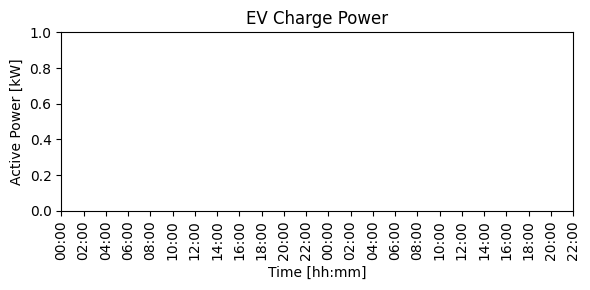

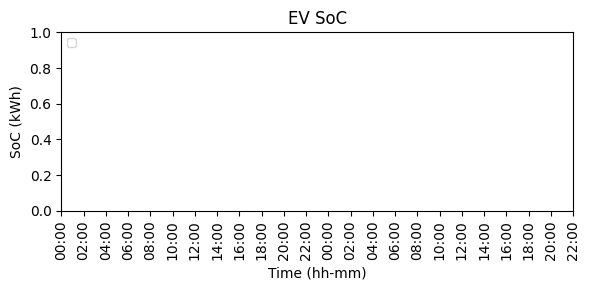

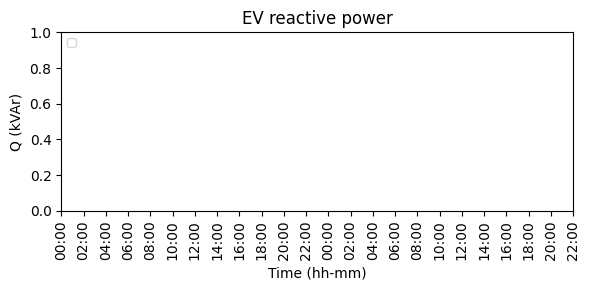

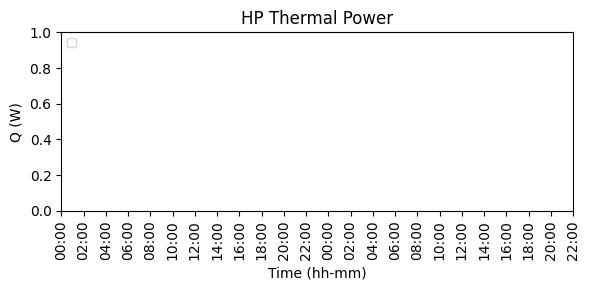

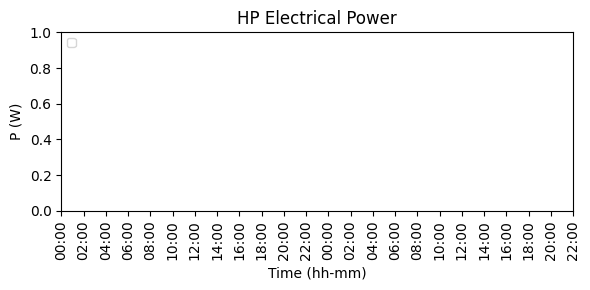

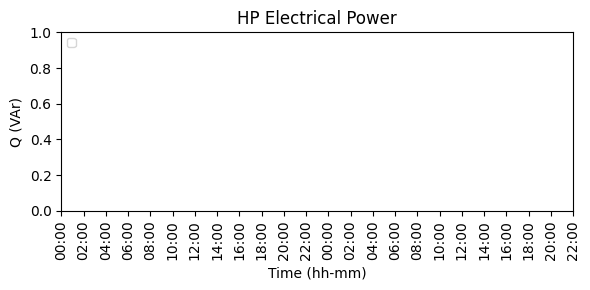

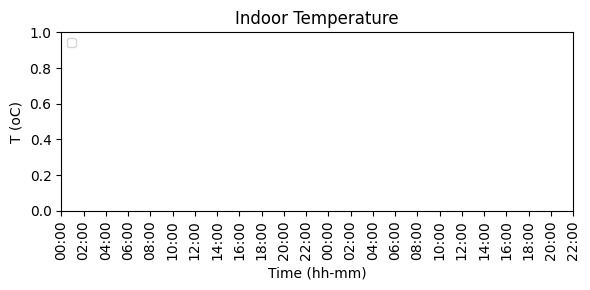

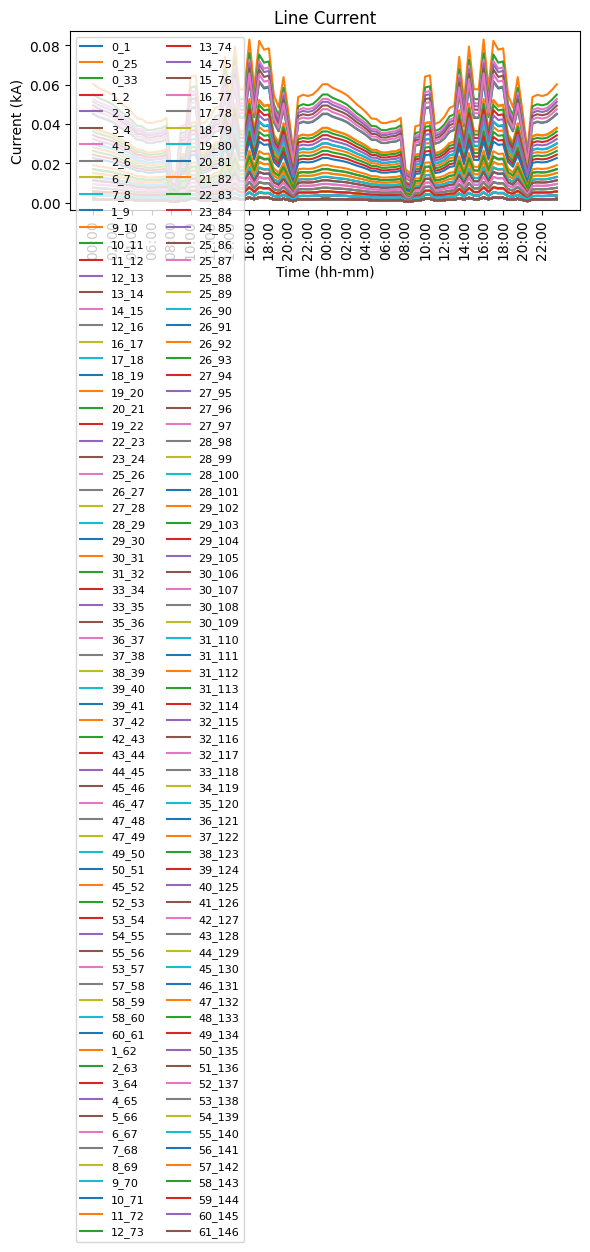

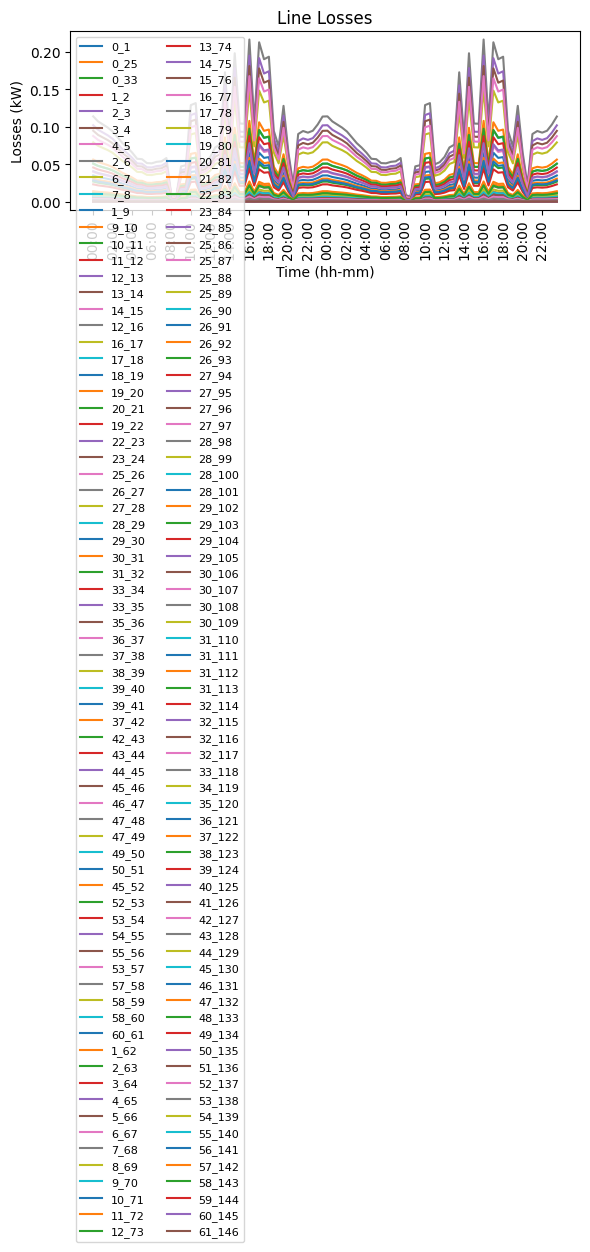

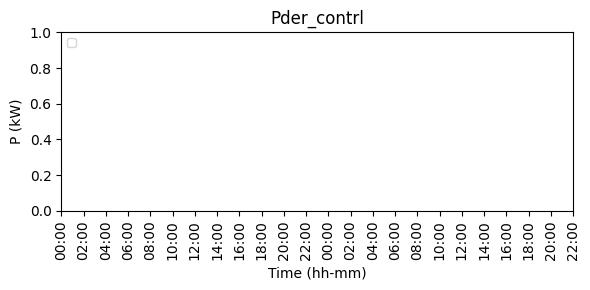

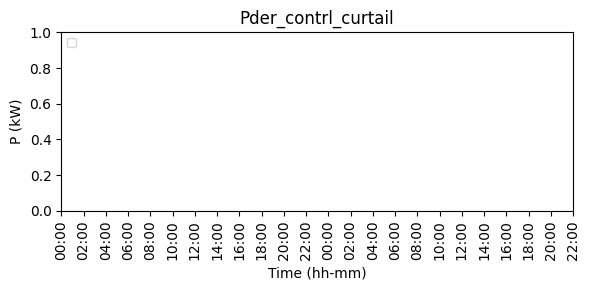

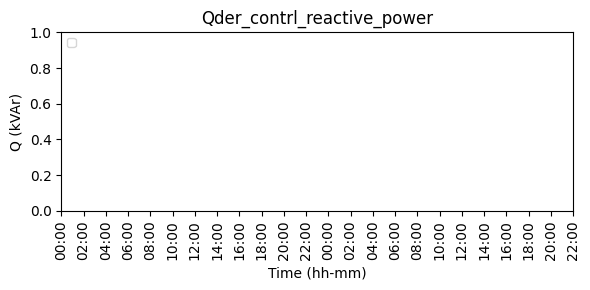

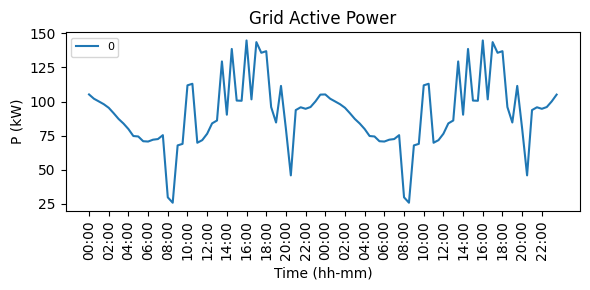

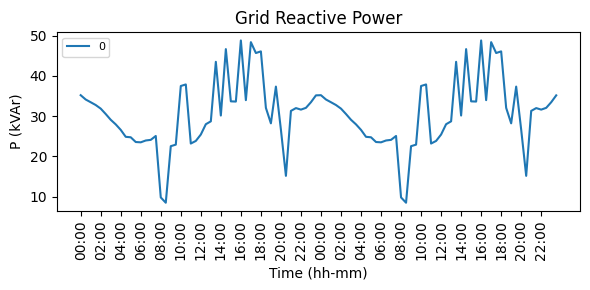

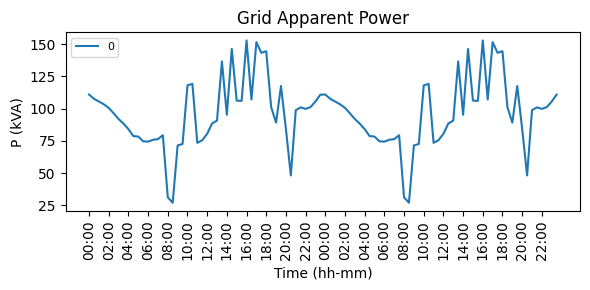

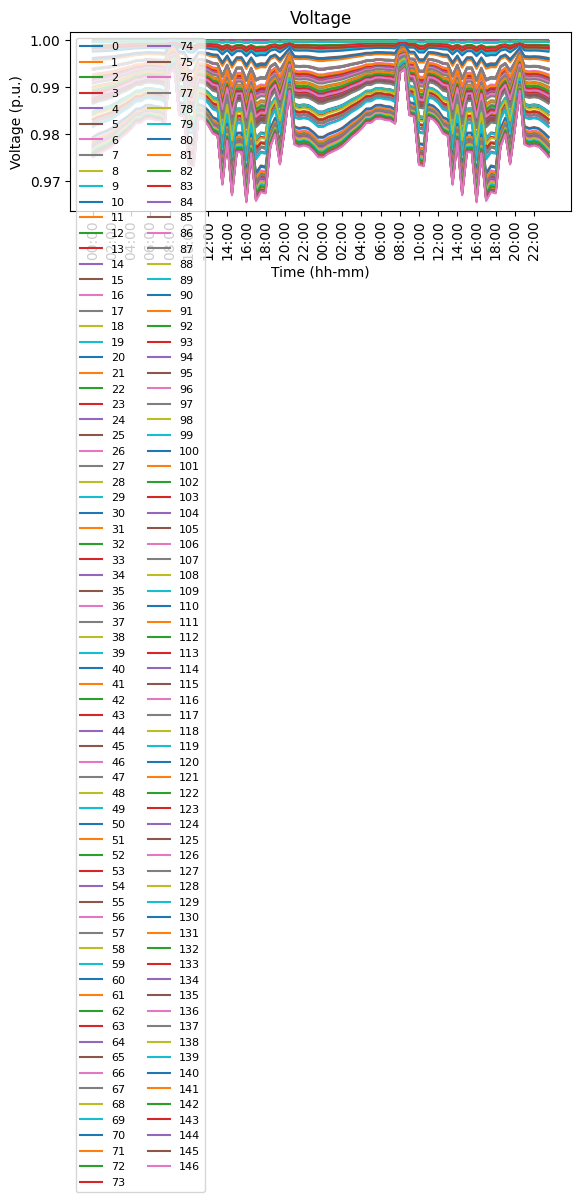

In [12]:
manager.plot_fun.result_df_plot(manager.results.pEVch*manager.anc_Vars.S_Base*1000,"EV Charge Power", "Time [hh:mm]" ,"Active Power [kW]")
manager.plot_fun.result_df_plot(manager.results.EVsoc*manager.anc_Vars.S_Base*1000,"EV SoC", "Time (hh-mm)" ,"SoC (kWh)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qEV*manager.anc_Vars.S_Base*1000,"EV reactive power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")

manager.plot_fun.result_df_plot(manager.results.Q_thermal,"HP Thermal Power", "Time (hh-mm)" ,"Q (W)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.p_hp*manager.anc_Vars.S_Base*1000*1000,"HP Electrical Power", "Time (hh-mm)" ,"P (W)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.q_hp*manager.anc_Vars.S_Base*1000*1000,"HP Electrical Power", "Time (hh-mm)" ,"Q (VAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.T_in,"Indoor Temperature", "Time (hh-mm)" ,"T (oC)",label="Yes")

manager.plot_fun.result_df_plot(manager.results.Line_curr*manager.anc_Vars.I_base,"Line Current", "Time (hh-mm)" ,"Current (kA)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.Line_losses*manager.anc_Vars.S_Base*1000,"Line Losses", "Time (hh-mm)" ,"Losses (kW)",label="Yes")

manager.plot_fun.result_df_plot(manager.results.pder_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_curtail_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl_curtail", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qder_contr*manager.anc_Vars.S_Base*1000,"Qder_contrl_reactive_power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")

manager.plot_fun.result_df_plot(manager.results.pgrid*manager.anc_Vars.S_Base*1000,"Grid Active Power", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qgrid*manager.anc_Vars.S_Base*1000,"Grid Reactive Power", "Time (hh-mm)" ,"P (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(np.sqrt(manager.results.pgrid**2+manager.results.qgrid**2)*manager.anc_Vars.S_Base*1000,"Grid Apparent Power", "Time (hh-mm)" ,"P (kVA)",label="Yes")


manager.plot_fun.result_df_plot((manager.results.v),"Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")


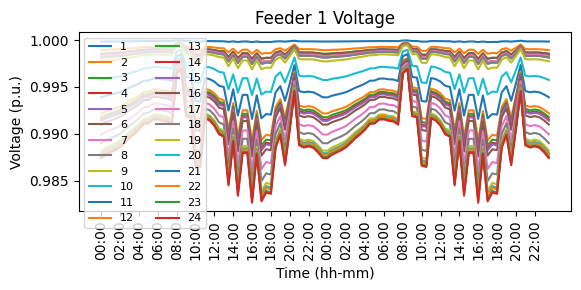

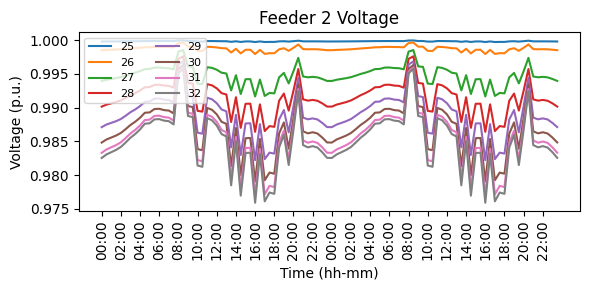

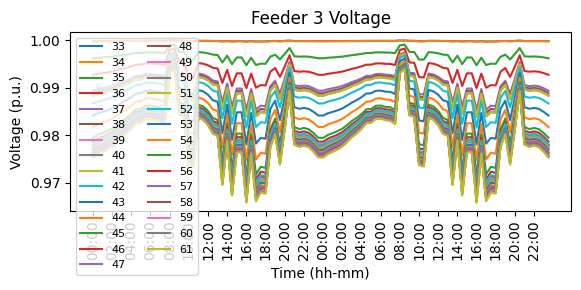

In [13]:
feeder1_buses=list(Feeder1.values())
feeder1_buses = [str(bus) for bus in feeder1_buses]

feeder2_buses=list(Feeder2.values())
feeder2_buses = [str(bus) for bus in feeder2_buses]

feeder3_buses=list(Feeder3.values())
feeder3_buses = [str(bus) for bus in feeder3_buses]

manager.plot_fun.result_df_plot(manager.results.v[feeder1_buses],"Feeder 1 Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")
manager.plot_fun.result_df_plot(manager.results.v[feeder2_buses],"Feeder 2 Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")
manager.plot_fun.result_df_plot(manager.results.v[feeder3_buses],"Feeder 3 Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")

### 20% EVs, 20%PVs and 20% HPs

In [15]:
sys.path.append('../../ADN_OPF/src')

from Manager import *

%run ../../Data/Electric_Network/full_three_feeders_Strovolides_Network.ipynb
net.sgen.drop(net.sgen.index, inplace=True)

# #######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index
# print(Y_bus_df)
# ################### OR ######################

Ybus_custom = build_ybus(net)

### Generate load/DER time scale data
file_path2 = '../../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

### Generate enviromen data
file_path2 = '../../Data/profiles/Enviroment_profiles/dataset2.xlsx'
enviroment_data = pd.read_excel(file_path2, index_col='Time')
enviroment_data=enviroment_data.iloc[0:96,:]

# print(Y_bus_df)
print(profiles.head())
print(enviroment_data.head())

############## Initialize model ######################

manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)
manager.anc_Vars.System_Data_DER.loc[:,'Controllable']=True

       Time  PV_Systems  PV_Rooftop  Load_Profile
0  00:00:00    0.000015    0.000015      0.122509
1  00:30:00    0.000015    0.000015      0.118885
2  01:00:00    0.000015    0.000015      0.116586
3  01:30:00    0.000016    0.000016      0.114244
4  02:00:00    0.000016    0.000016      0.111212
                      Tout  SolGlob
Time                               
2019-02-21T18:30:00Z   0.1        0
2019-02-21T19:00:00Z   0.2        0
2019-02-21T19:30:00Z   0.3        0
2019-02-21T20:00:00Z   0.3        0
2019-02-21T20:30:00Z   0.3        0


In [ ]:
num_steps = int((manager.timeframe * 60) / manager.time_interval)
temp_pref = temp_preference = pd.DataFrame({'Tmin': [20.99] * num_steps,'Tmax': [21.01] * num_steps})

activate_random_EVs(
    percentage=20, feeder_buses=Feeder1_load_bus, manager=manager, df_arrival=df_arrival, loc_arrival=loc_arrival, scale_arrival=scale_arrival,
    df_departure=df_departure,loc_departure=loc_departure,scale_departure=scale_departure, a=a, b=b, values_weekdays=values_weekdays, probabilities_weekdays=probabilities_weekdays)

activate_random_FlexBuildings(percentage=20, feeder_buses=Feeder1_load_bus, manager=manager, temp_preference=temp_pref
)

activate_random_EVs(
    percentage=20, feeder_buses=Feeder2_load_bus, manager=manager, df_arrival=df_arrival, loc_arrival=loc_arrival, scale_arrival=scale_arrival,
    df_departure=df_departure,loc_departure=loc_departure,scale_departure=scale_departure, a=a, b=b, values_weekdays=values_weekdays, probabilities_weekdays=probabilities_weekdays)

activate_random_FlexBuildings(percentage=20, feeder_buses=Feeder2_load_bus, manager=manager, temp_preference=temp_pref
)

activate_random_EVs(
    percentage=20, feeder_buses=Feeder3_load_bus, manager=manager, df_arrival=df_arrival, loc_arrival=loc_arrival, scale_arrival=scale_arrival,
    df_departure=df_departure,loc_departure=loc_departure,scale_departure=scale_departure, a=a, b=b, values_weekdays=values_weekdays, probabilities_weekdays=probabilities_weekdays)

activate_random_FlexBuildings(percentage=20, feeder_buses=Feeder3_load_bus, manager=manager, temp_preference=temp_pref
)

## Backup Codes

In [14]:
# # Custom Add EVs since in pandapower EVs are not available
# num_steps = int((manager.timeframe * 60) / manager.time_interval)
# temp_pref = temp_preference = pd.DataFrame({'Tmin': [20.99] * num_steps,'Tmax': [21.01] * num_steps})

# manager.anc_Vars.addEV(node=Feeder1_load_bus[0],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[1],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[2],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[3],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[4],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=19,arrival=[32,32+48],departure=[10,10+48],distance=[140,140])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[5],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=80, EV_cons=18,arrival=[40,40+48],departure=[35,35+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[6],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[37,37+48],departure=[17,17+48],distance=[200,200])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[7],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=19,arrival=[36,36+48],departure=[11,11+48],distance=[10,10])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[8],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=19,arrival=[30,30+48],departure=[16,16+48],distance=[10,10])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[9],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[37,37+48],departure=[13,13+48],distance=[2,2])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[10],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[11],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[12],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[13],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[14],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=19,arrival=[32,32+48],departure=[10,10+48],distance=[140,140])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[15],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=80, EV_cons=18,arrival=[40,40+48],departure=[35,35+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[16],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[37,37+48],departure=[17,17+48],distance=[200,200])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[17],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=19,arrival=[36,36+48],departure=[11,11+48],distance=[10,10])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[18],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=19,arrival=[30,30+48],departure=[16,16+48],distance=[10,10])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[19],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[37,37+48],departure=[13,13+48],distance=[2,2])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[20],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[37,37+48],departure=[17,17+48],distance=[200,200])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[21],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=19,arrival=[36,36+48],departure=[11,11+48],distance=[10,10])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[22],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=19,arrival=[30,30+48],departure=[16,16+48],distance=[10,10])
# manager.anc_Vars.addEV(node=Feeder1_load_bus[23],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[37,37+48],departure=[13,13+48],distance=[2,2])

# manager.anc_Vars.addEV(node=Feeder2_load_bus[0],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[26,26+48],departure=[15,15+48],distance=[150,150])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[1],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[32,32+48],departure=[14,14+48],distance=[160,160])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[2],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[36,36+48],departure=[13,13+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[3],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=16, EV_SoC_max=100, EV_cons=15, arrival=[32,32+48],departure=[14,14+48],distance=[135,135])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[4],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[11,11+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[5],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[6],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[7],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[8],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[26,26+48],departure=[15,15+48],distance=[150,150])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[9],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[32,32+48],departure=[14,14+48],distance=[160,160])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[10],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[36,36+48],departure=[13,13+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[11],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=16, EV_SoC_max=100, EV_cons=15, arrival=[32,32+48],departure=[14,14+48],distance=[135,135])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[12],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[11,11+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[13],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[14],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[15],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[16],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[26,26+48],departure=[15,15+48],distance=[150,150])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[17],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[32,32+48],departure=[14,14+48],distance=[160,160])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[18],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[36,36+48],departure=[13,13+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[19],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=16, EV_SoC_max=100, EV_cons=15, arrival=[32,32+48],departure=[14,14+48],distance=[135,135])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[20],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[11,11+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[21],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[22],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[23],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[24],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[26,26+48],departure=[15,15+48],distance=[150,150])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[25],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[32,32+48],departure=[14,14+48],distance=[160,160])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[26],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[36,36+48],departure=[13,13+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[27],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=16, EV_SoC_max=100, EV_cons=15, arrival=[32,32+48],departure=[14,14+48],distance=[135,135])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[28],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[11,11+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[29],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[30],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
# manager.anc_Vars.addEV(node=Feeder2_load_bus[31],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])


# manager.anc_Vars.addEV(node=Feeder3_load_bus[0],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[1],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=19,arrival=[32,32+48],departure=[10,10+48],distance=[140,140])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[2],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=80, EV_cons=18,arrival=[40,40+48],departure=[35,35+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[3],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[37,37+48],departure=[17,17+48],distance=[200,200])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[4],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=19,arrival=[36,36+48],departure=[11,11+48],distance=[10,10])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[5],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=19,arrival=[30,30+48],departure=[16,16+48],distance=[10,10])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[6],P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[37,37+48],departure=[13,13+48],distance=[2,2])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[7],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[26,26+48],departure=[15,15+48],distance=[150,150])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[8],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[32,32+48],departure=[14,14+48],distance=[160,160])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[9],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[36,36+48],departure=[13,13+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[10],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=16, EV_SoC_max=100, EV_cons=15, arrival=[32,32+48],departure=[14,14+48],distance=[135,135])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[11],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[11,11+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[12],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[30,30+48],departure=[13,13+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[13],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=16,arrival=[35,35+48],departure=[11,11+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[14],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[30,30+48],departure=[14,14+48],distance=[30,30])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[15],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=17,arrival=[39,39+48],departure=[14,14+48],distance=[140,140])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[16],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=100, EV_cons=19,arrival=[34,34+48],departure=[11,11+48],distance=[35,35])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[17],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=100, EV_cons=18,arrival=[24,24+48],departure=[14,14+48],distance=[45,45])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[18],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[32,32+48],departure=[14,14+48],distance=[160,160])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[19],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[36,36+48],departure=[13,13+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[20],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=16, EV_SoC_max=100, EV_cons=15, arrival=[32,32+48],departure=[14,14+48],distance=[135,135])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[21],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[11,11+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[22],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[30,30+48],departure=[13,13+48],distance=[5,5])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[23],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=16,arrival=[35,35+48],departure=[11,11+48],distance=[1,1])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[24],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[30,30+48],departure=[14,14+48],distance=[30,30])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[25],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=17,arrival=[39,39+48],departure=[14,14+48],distance=[140,140])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[26],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=100, EV_cons=19,arrival=[34,34+48],departure=[11,11+48],distance=[35,35])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[27],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=100, EV_cons=18,arrival=[24,24+48],departure=[14,14+48],distance=[45,45])
# manager.anc_Vars.addEV(node=Feeder3_load_bus[28],P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=100, EV_cons=18,arrival=[24,24+48],departure=[14,14+48],distance=[45,45])

# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[0], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[1], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[2], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[3], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[4], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[5], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[6], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[7], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[8], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[9], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[10], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[11], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[12], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[13], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[14], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[15], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[16], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[17], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[18], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[19], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[20], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[21], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[22], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder1_load_bus[23], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)

# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[0], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[1], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[2], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[3], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[4], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[5], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[6], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[7], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[8], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[9], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[10], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[11], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[12], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[13], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[14], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[15], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[16], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[17], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[18], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[19], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[20], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[21], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[22], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[23], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[24], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[25], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[26], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[27], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[28], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[29], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[30], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder2_load_bus[31], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)

# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[0], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[1], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[2], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[3], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[4], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[5], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[6], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[7], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[8], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[9], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[10], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[11], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[12], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[13], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[14], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[15], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[16], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[17], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[18], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[19], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[20], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[21], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[22], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[23], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[24], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[25], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[26], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[27], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)
# manager.anc_Vars.addFlexBuilding(node=Feeder3_load_bus[28], P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf", temp_preference=temp_pref)


# # print(manager.anc_Vars.system_data_ev)
# # print(manager.anc_Vars.system_data_ev_char)
# # print(manager.anc_Vars.system_data_hp)